In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# In This code i am using library Result for 3D point cloud

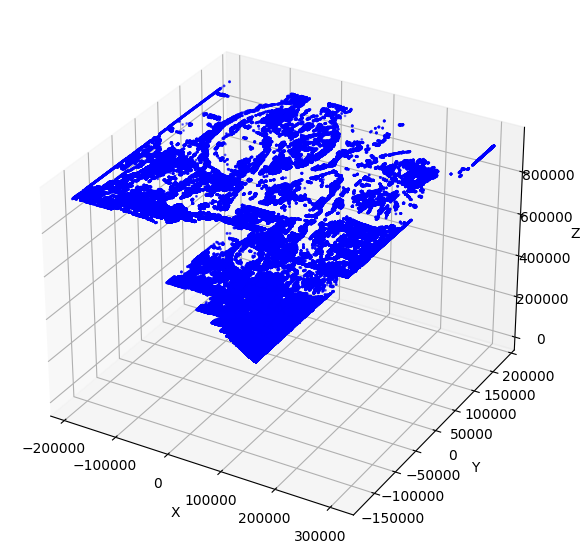

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


path = '/content/drive/My Drive/m22ee002_q2/'
imgleft = cv2.imread(path + 'bikeL.png', cv2.IMREAD_GRAYSCALE)
imgright = cv2.imread(path + 'bikeR.png', cv2.IMREAD_GRAYSCALE)


intrmatrix_left = np.array([[5299.313, 0, 1263.818],
                                  [0, 5299.313, 977.763],
                                  [0, 0, 1]])

baseline = 177.288




stereo = cv2.StereoSGBM_create(minDisparity=0,
                                numDisparities=192,
                                blockSize=15,
                                P1=8 * 3 * 15 ** 2,
                                P2=32 * 3 * 15 ** 2,
                                disp12MaxDiff=1,
                                uniquenessRatio=10,
                                speckleWindowSize=100,
                                speckleRange=32,
                                mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
disparity = stereo.compute(imgleft, imgright)


dispa_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


dispar_smoothed = cv2.bilateralFilter(dispa_normalized, 9, 75, 75)

depth_map = baseline / (dispar_smoothed + 1e-6)


depth_map[depth_map == np.inf] = 0
depth_map = depth_map.astype(np.float32)

point_cloud = cv2.reprojectImageTo3D(dispar_smoothed, Q=np.float32([[1, 0, 0, -1263.818],
                                                                        [0, 1, 0, -977.763],
                                                                        [0, 0, 0, 5299.313],
                                                                        [0, 0, 1/baseline, 0]]))


valid_points = point_cloud.reshape(-1, 3)[~np.isnan(depth_map).flatten()]


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_points[:, 0], valid_points[:, 1], valid_points[:, 2], c='b', marker='o', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


# code from scratch

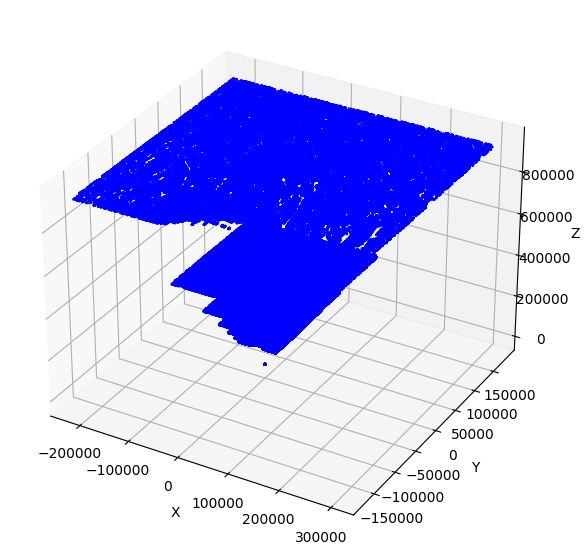

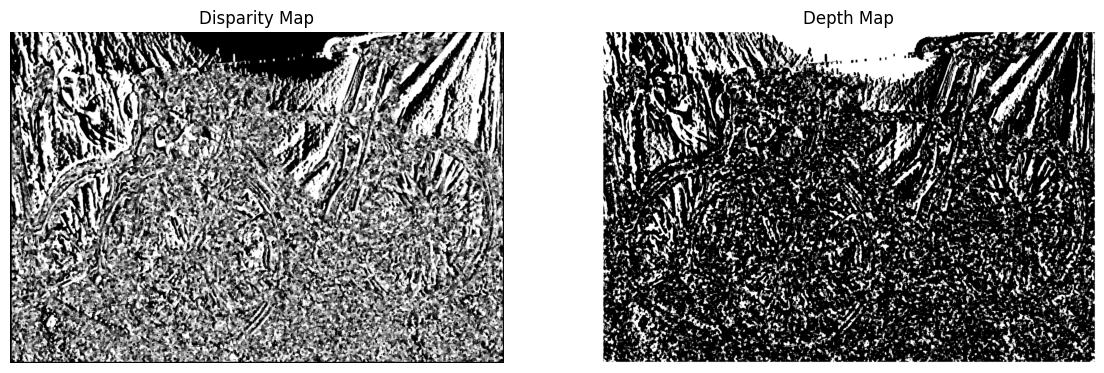

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def stereo_match(leftimg, rightimg, block_size=15, num_disparities=16):
    if leftimg is None or rightimg is None:
        print("Error: Unable to load one or both of the images.")
        return None

    height, width = leftimg.shape
    half_block = block_size // 2
    max_offset = num_disparities // 2
    disparity_map = np.zeros_like(leftimg, dtype=np.float32)

    for y in range(half_block, height - half_block):
        for x in range(half_block, width - half_block):
            block_left = leftimg[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            min_ssd = float('inf')
            best_offset = 0

            for offset in range(max_offset):
                if x - half_block - offset >= 0:
                    block_right = rightimg[y - half_block:y + half_block + 1, x - half_block - offset:x + half_block + 1 - offset]
                    ssd = np.sum((block_left - block_right) ** 2)

                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_offset = offset

            disparity_map[y, x] = best_offset

    return disparity_map

def compute_depth(disparity_map, baseline, focal_length):
    depth_map = baseline * focal_length / (disparity_map + 1e-6)
    return depth_map

def compute_3d_point_cloud(disparity_map, baseline, focal_length, intrinsic_matrix_left):
    if disparity_map is None:
        return None

    height, width = disparity_map.shape
    point_cloud = np.zeros((height, width, 3), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            disparity = disparity_map[y, x]
            if disparity > 0:
                depth = baseline * focal_length / (disparity + 1e-6)
                point_cloud[y, x] = [(x - intrinsic_matrix_left[0, 2]) * depth / intrinsic_matrix_left[0, 0],
                                     (y - intrinsic_matrix_left[1, 2]) * depth / intrinsic_matrix_left[1, 1],
                                     depth]

    return point_cloud

def plot_3d_point_cloud(point_cloud):
    if point_cloud is not None:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(point_cloud[:, :, 0].flatten(), point_cloud[:, :, 1].flatten(), point_cloud[:, :, 2].flatten(), c='b', marker='o', s=1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    else:
        print("Error: Unable to compute 3D point cloud due to invalid disparity map.")

def load_images(left_image_path, right_image_path):
    image_left = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
    image_right = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)
    return image_left, image_right

def main():

    left_image_path = '/content/drive/My Drive/m22ee002_q2/bikeL.png'
    right_image_path = '/content/drive/My Drive/m22ee002_q2/bikeR.png'


    intrinsic_matrix_left = np.array([[5299.313, 0, 1263.818],
                                      [0, 5299.313, 977.763],
                                      [0, 0, 1]])

    baseline = 177.288
    focal_length = intrinsic_matrix_left[0, 0]


    imgleft, imgright = load_images(left_image_path, right_image_path)


    disparity_map = stereo_match(imgleft, imgright)


    depth_map = compute_depth(disparity_map, baseline, focal_length)


    point_cloud = compute_3d_point_cloud(disparity_map, baseline, focal_length, intrinsic_matrix_left)


    plot_3d_point_cloud(point_cloud)


    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(disparity_map, cmap='gray')
    plt.title('Disparity Map')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap='gray')
    plt.title('Depth Map')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()
